<a href="https://colab.research.google.com/github/Shivcharan989/XploreDL/blob/main/Predictive_Maintenence_Anomaly_Detection/Anomaly_Detection_with_Predictive_Maintenance_using_Auto_Encoder_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline


from numpy.random import seed
from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

import tensorflow as tf    
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Instructions for updating:
non-resource variables are not supported in the long term


The main idea is to "compress" the data values into a low-dimensional representation that captures the correlations and interactions between 
the various variables using an autoencoder neural network.

The data is first trained with normal healthy data , we identify a threshold in its normal behaviour and later use it for identifiying the anomaly, therby identifying the issue with sensor before it even happens


In [ ]:
dataset = pd.read_excel('m_1.xlsx')
dataset['timestamp']=pd.to_datetime(dataset['timestamp'])
dataset_original = dataset.set_index(['timestamp'])

In [ ]:
optimal = dataset_original[['cpu_util_percent','mem_util_percent','disk_io_percent','net_in','net_out']]

In [ ]:
training = optimal['2011-05-04 12:00:20':]
testing= optimal['2011-05-01 12:00:10':'2011-05-04 12:00:10']


In [ ]:
training.to_csv("m_1_anamoly_train_data.csv")

In [ ]:
training

,cpu_util_percent,mem_util_percent,disk_io_percent,net_in,net_out
timestamp,,,,,
2011-05-04 12:00:20,27,95,2,36.77,25.94
2011-05-04 12:00:30,28,96,2,36.77,25.94
2011-05-04 12:00:40,28,96,2,36.77,25.94
2011-05-04 12:01:00,27,97,3,36.77,25.94
2011-05-04 12:01:10,29,96,3,36.77,25.94
...,...,...,...,...,...
2011-05-07 16:37:30,51,94,6,41.94,29.46
2011-05-07 16:37:40,55,94,6,41.94,29.47
2011-05-07 16:37:50,36,94,6,41.94,29.47


In [ ]:
testing.to_csv("m_1_anamoly_test_data.csv")

In [ ]:
#Performing Scaling for Maximizing the model output.
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(training), 
                              columns=training.columns, 
                              index=training.index)
X_test = pd.DataFrame(scaler.transform(testing), 
                             columns=testing.columns, 
                             index=testing.index)

In [ ]:
X_train

,cpu_util_percent,mem_util_percent,disk_io_percent,net_in,net_out
timestamp,,,,,
2011-05-04 12:00:20,0.209877,0.88,0.020408,0.0,0.000000
2011-05-04 12:00:30,0.222222,0.92,0.020408,0.0,0.000000
2011-05-04 12:00:40,0.222222,0.92,0.020408,0.0,0.000000
2011-05-04 12:01:00,0.209877,0.96,0.040816,0.0,0.000000
2011-05-04 12:01:10,0.234568,0.92,0.040816,0.0,0.000000
...,...,...,...,...,...
2011-05-07 16:37:30,0.506173,0.84,0.102041,1.0,0.997167
2011-05-07 16:37:40,0.555556,0.84,0.102041,1.0,1.000000
2011-05-07 16:37:50,0.320988,0.84,0.102041,1.0,1.000000


In [ ]:
X_test

,cpu_util_percent,mem_util_percent,disk_io_percent,net_in,net_out
timestamp,,,,,
2011-05-01 12:00:10,0.037037,0.44,0.000000,-0.833656,-0.807365
2011-05-01 12:00:20,0.000000,0.44,0.000000,-0.833656,-0.807365
2011-05-01 12:00:30,0.012346,0.44,0.000000,-0.833656,-0.807365
2011-05-01 12:00:40,0.024691,0.44,0.000000,-0.833656,-0.807365
2011-05-01 12:00:50,0.024691,0.44,0.000000,-0.833656,-0.807365
...,...,...,...,...,...
2011-05-04 11:59:30,0.111111,0.88,0.000000,0.000000,0.000000
2011-05-04 11:59:40,0.098765,0.84,0.000000,0.000000,0.000000
2011-05-04 11:59:50,0.135802,0.84,0.000000,0.000000,0.000000


In [ ]:
seed(10)
act_func = 'elu'
import warnings
warnings.filterwarnings('ignore')


model=Sequential()
 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

NUM_EPOCHS=100
BATCH_SIZE=10

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Train on 26056 samples, validate on 1372 samples
Epoch 1/100
26056/26056 [==============================] - 3s 134us/step - loss: 0.0183 - val_loss: 0.0118
Epoch 2/100
26056/26056 [==============================] - 3s 107us/step - loss: 0.0051 - val_loss: 0.0224
Epoch 3/100
26056/26056 [==============================] - 3s 106us/step - loss: 0.0044 - val_loss: 0.0201
Epoch 4/100
26056/26056 [==============================] - 3s 104us/step - loss: 0.0043 - val_loss: 0.0206
Epoch 5/100
26056/26056 [==============================] - 3s 109us/step - loss: 0.0042 - val_loss: 0.0192
Epoch 6/100
26056/26056 [==============================] - 3s 106us/step - loss: 0.0041 - val_loss: 0.0178
Epoch 7/100
26056/26056 [==============================] - 3s 106us/step - loss: 0.0040 - val_loss: 0.0210
Epoch 8/100
26056/26056 [==============================] - 3s 105us/step - loss: 0.0039 - val_loss: 0.0186
Epoch 9/100
26056/26056 [==============================] - 3s 106us/step - loss: 0.0038 - val_l

In [ ]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.13
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
#scored = pd.concat([scored,scored_train])

(0.0, 0.5)

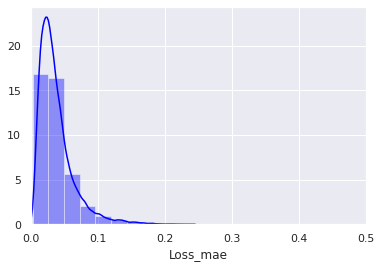

In [ ]:
#By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly.

plt.figure()
sns.distplot(scored_train['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.5])

In [ ]:
scored_train.head()

,Loss_mae,Threshold,Anomaly
timestamp,,,
2011-05-04 12:00:20,0.081730,0.13,False
2011-05-04 12:00:30,0.094083,0.13,False
2011-05-04 12:00:40,0.094083,0.13,False
2011-05-04 12:01:00,0.105570,0.13,False
2011-05-04 12:01:10,0.090454,0.13,False


From the above loss distribution, let us try a threshold of 0.13 for flagging an anomaly.Here in Train set the threshold crosses only in few places
 We can then calculate the loss in the test set, to check when the output crosses the anomaly threshold.

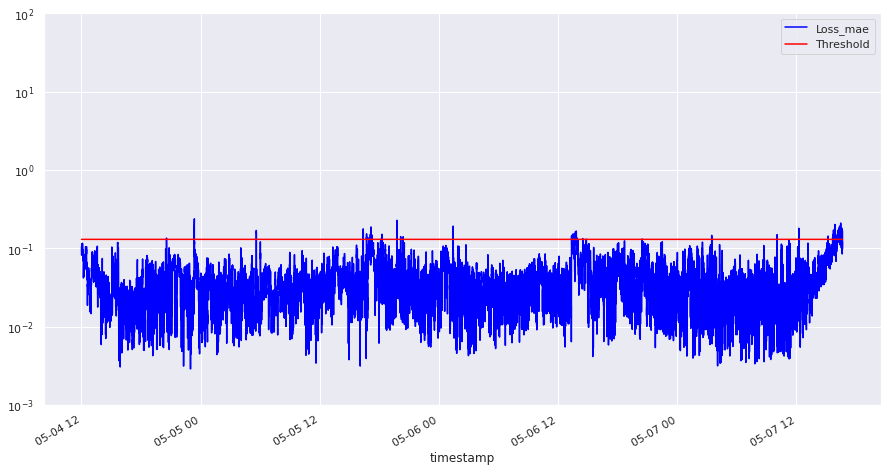

In [ ]:
scored_train.plot(logy=True,  figsize = (15,8), ylim = [1e-3,1e2], color = ['blue','red'])

In [ ]:
#Prediction for test data
X_pred_test = model.predict(np.array(X_test))
X_pred_test = pd.DataFrame(X_pred_test, 
                      columns=X_test.columns)
X_pred_test.index = X_test.index


In [ ]:
#LOss MAE is calculated to identify Anomaly as it compresses the data to understand the insights.
scored_test = pd.DataFrame(index=X_test.index)
scored_test['Loss_mae'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)
scored_test['Threshold'] = 0.13
scored_test['Anomaly'] = scored_test['Loss_mae'] > scored_test['Threshold']

In [ ]:
scored_test.head()

,Loss_mae,Threshold,Anomaly
timestamp,,,
2011-05-01 12:00:10,0.555381,0.13,True
2011-05-01 12:00:20,0.553141,0.13,True
2011-05-01 12:00:30,0.553948,0.13,True
2011-05-01 12:00:40,0.554694,0.13,True
2011-05-01 12:00:50,0.554694,0.13,True


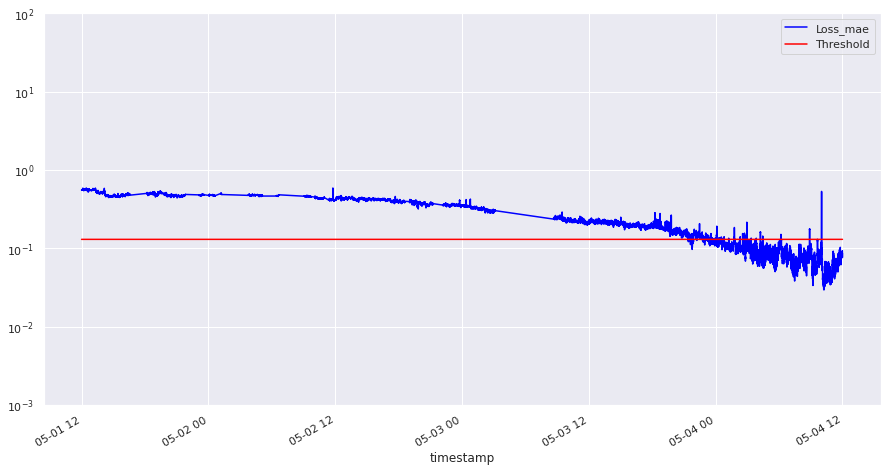

In [ ]:
#Dataset set quality for this data is not good, somehow we are able to identify points where the  points crosses the threshold of 0.13 and these points can be labelled as anomaly points
scored_test.plot(logy=True,  figsize = (15,8), ylim = [1e-3,1e2], color = ['blue','red'])